<a href="https://colab.research.google.com/github/aleksandra-boop/PRA3024/blob/main/Aleksandra's_Gravitational_Wave_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Downloading the data from the detectors
import sys
!{sys.executable} -m pip install lalsuite pycbc

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf


     |████████████████████████████████| 27.3MB 157kB/s 
     |████████████████████████████████| 3.2MB 42.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 1.6MB 38.1MB/s 
     |████████████████████████████████| 890kB 50.0MB/s 
     |████████████████████████████████| 481kB 39.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 3.2MB 38.9MB/s 
  Created wheel for pycbc: filename=PyCBC-1.17.0-cp36-cp36m-linux_x86_64.whl size=5711439 sha256=7931d343260fd3641b9b623f4fccd12158eb8a3c01888ac66e6ea128cc918917
  Stored in directory: /root/.cache/pip/wheels/51/1c/69/7de581c512e9465dad0d6a955c4a947425799fe14f6226d3a8
Successfully built pycbc
  Created wheel for ligo-segments: filename=ligo_segments-1.3.0-cp36-cp36m-linux_x86_64.whl size=84676 sha256=084bd7e9a4b90601d6f22557d3

# Problem 1

In [19]:
#Initial imports
from __future__ import division

import numpy
import lal
import lalsimulation
import pylab

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
from numpy import arange 
import pycbc.psd
from pycbc.psd import interpolate
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.frame import read_frame
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from numpy import arange
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
import numpy
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma

#  Downsampling the data at a sampling rate of 2048Hz

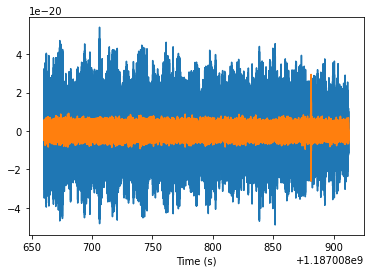

In [20]:
#Selecting desired event
merger = Merger("GW170817")
strain, stilde = {}, {}

for ifo in ['H1', 'L1']:
    #We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    #Removing the low frequency and downsampling to 2048Hz
    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
    strain[ifo] = strain[ifo].crop(2, 2)
    #Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()
    pylab.plot(strain[ifo].sample_times, strain[ifo])

#print (strain.delta_t)
pylab.xlabel('Time (s)')
pylab.show()

#We have now downsampled and plotted the data file

# Calculating the matched filter between the given data and atemplate waveform
Matched filtering involves aligning a potential dignal and data, then integrating over them. The large value after integration suggests there's a signal in the data that aligns with the template. 





0.003968253968253968

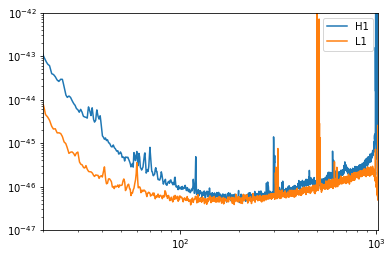

In [21]:
#First, we will plot the power spectral density of the data;
#it is important to whiten the data or in order to find the SNR

psds = {}
for ifo in ['H1', 'L1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)

pylab.legend()
psds[ifo].delta_f

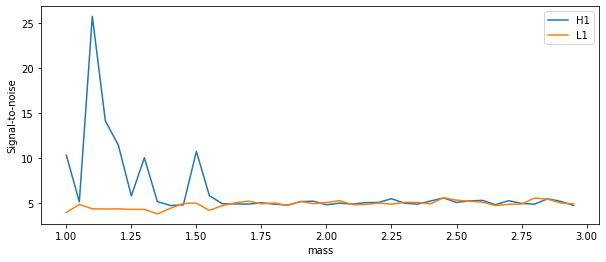

In [22]:
Snr_list = []
snrs = {}
interval = 0.05
masses = arange(1,3,interval)

#We will be searching through different masses to find the one that fits the best
for ifo in ['H1', 'L1']:
  for m in (arange(1,3,interval)):
    m = round(m,2)
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=15.0)
    
    #Resizing to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)

    snr = matched_filter(template, strain[ifo],
                        psd=psds[ifo], 
                        low_frequency_cutoff=15.0)
    snr1 = snr.crop(4 + 4, 4)
    snrs[ifo] = Snr_list.append(max(abs(snr1)))
  snrs[ifo] = Snr_list
  Snr_list = []

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label = 'H1')
pylab.plot(masses, snrs['L1'], label = 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

# Finding the best mass

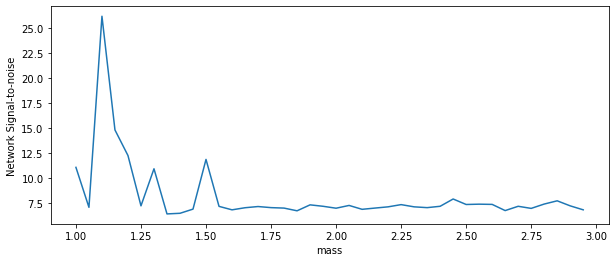

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [23]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(masses, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

#Printing a plot of SNR vs mass of the system
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

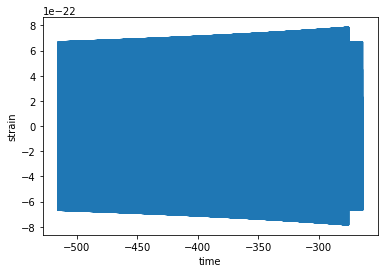

In [24]:
#For this part we assume equal masses
ifo = 'L1'
m = masses[ii]
conditioned = strain[ifo]
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(strain[ifo]))

#The waveform begins at the start of the vector, 
#so we need to shift the data in such a way, 
#that the merger is at the beginning of the data. 
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

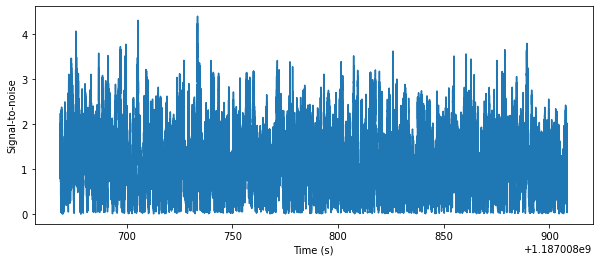

We found a signal at 1187008733.4942384s with SNR 4.3869121810323755


In [25]:
ifo = 'L1'
conditioned = strain[ifo]

snr = matched_filter(template, conditioned,
                     psd=psds[ifo], low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

#Printing SNR vs. time
print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [26]:
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

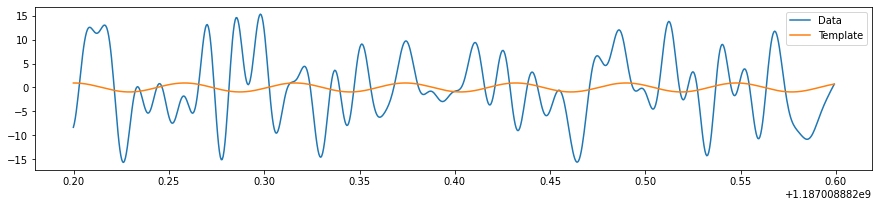

In [11]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

tapered = aligned.highpass_fir(5, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(5., 512).lowpass_fir(80, 512)
white_template = white_template.highpass_fir(5, 512).lowpass_fir(80, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.2)
white_template = white_template.time_slice(merger.time-.2, merger.time+.2)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

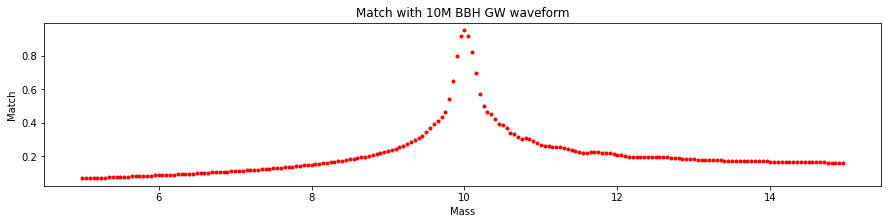

In [12]:
f_low = 30
sample_rate = 4096
masses = arange(5,15,0.05)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[15, 3])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

#From the graph it can be concluded that the more similar to eachother the masses are the cloeser to eachother are the waveforms

# Problem 2

In [27]:
#Importing numpy and loading the data
import numpy as np
d = np.load('noise_ts_4096Hz (2).npy')
import pycbc.types 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

In [28]:
#Calculating power spectral density from the data
from pycbc.psd import welch, interpolate

#Interpolating the PSD to needed frequency
psds = interpolate(welch(d), 1.0 / d.duration)

Maximum SNR: 6.545257353642936. No gravitational wave detected.


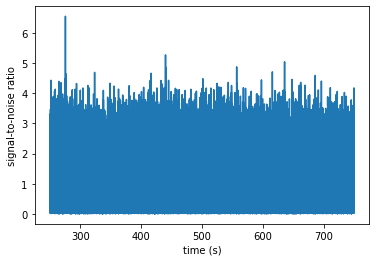

In [29]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab

flow = 30 #Hz
stilde = data.to_frequencyseries()

interval = 0.05
masses = arange(5,10,interval)
maxSNR = 0
pltSNR = 0
maxhp = 0

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, delta_f=stilde.delta_f)
  hp.resize(len(stilde))
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                        low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
 
  if max(abs(snr)) > maxSNR:
    maxSNR = max(abs(snr))
    pltSNR = snr
    maxhp = hp


if maxSNR < 8: 
  print("Maximum SNR: {}. No gravitational wave detected.".format(maxSNR))
else:
  print("Maximum SNR: {}. Gravitational wave detected.".format(maxSNR))

pylab.plot(pltSNR.sample_times, abs(pltSNR))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

In [30]:
#Whitening the data
#We do it this way so that we can whiten both the template and the data
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)

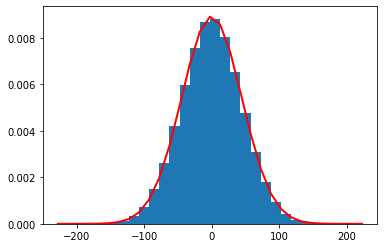

In [31]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
 
mu, sigma, shape = mean(white_data), stdev(white_data), white_data.shape[0] # mean, standard deviation, shape
s = np.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

In [32]:
from pycbc.waveform import get_fd_waveform

#Generating waveforms for comparison
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0) #Luminosity distance = 500 Mpc

In [33]:
from pycbc.filter import sigmasq

intervals = 1000
data_slice = int(len(data)/intervals)
SNRlist = []

for i in range(0, intervals):

  data_chunk = data[i * data_slice: (i+1)*data_slice]
  psd = interpolate(welch(data_chunk), 1.0 / d.duration)
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)
  SNR = (pycbc.filter.sigmasq(hp, psds))**0.5
  SNRlist.append(SNR)

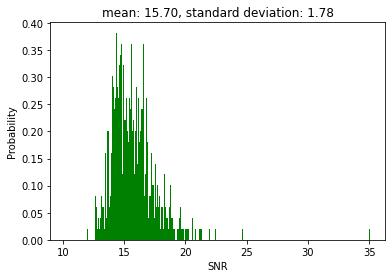

In [34]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

# Plotting histogram
plt.hist(SNRlist, bins = 500, color = "green", density=True)

# Plotting Best Fit
mu, sigma = mean(SNRlist), stdev(SNRlist)
y = norm.pdf(25, mu, sigma)
plt.plot(25, y)

plt.title('mean: {:.2f}, standard deviation: {:.2f}'.format(mu, sigma))
plt.xlabel("SNR")
plt.ylabel("Probability")


#Print the plot
plt.show()

#With this plot we have proved that the noise doesn't follow the stationary Gaussian distribution

# Problem 3

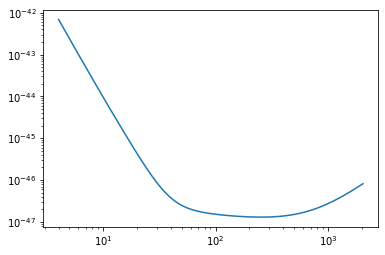

In [17]:
import pycbc.psd
import numpy as np

flow = 4.0
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

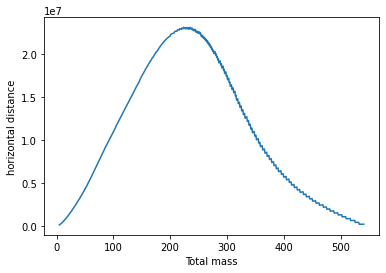

In [16]:
from pycbc.filter import sigmasq
flow = 4.0

interval = 1
masses = arange(5,1000,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('Horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

3.2: Increasing the horison distance helps with detection of certain events, as the SNR is highier for events with highier horison distance. From the graph we can see that for event of total mass 200 SNR is highier than for events of total mass 10. 

From the graph, we can also clearly that for certain masses the horizon distance starts to decrease. This is happening due to aLigo detector's due to frequency band. The events with frequencies outside of the detectors range will produce lower SNR. This explains why the horizon distance decreases with the masses, as heavier objects create higier frequencies. 

aLigo detector in comparison to Einstein telescope is less sensitive, because the curve is shifted towards bigger massess. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


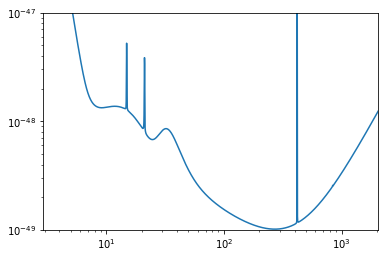

In [14]:
import pycbc.psd
import numpy as np

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(min(psd.sample_frequencies), max(psd.sample_frequencies))
pylab.ylim(1e-49, 1e-47)
pylab.show()

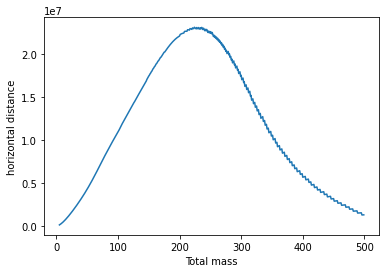

In [15]:
from pycbc.filter import sigmasq
flow = 4.0 #Hz

interval = 1
masses = arange(5,500,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()